# **Test technique-Stage data science / OSINT**
## **Scraping web et analyse de sentiment**

### **Le scraping**

In [ ]:
import requests
import pandas as pd
from datetime import datetime
import time

def scrape_reddit_json(subreddit="france", limit=50):
    url = f"https://www.reddit.com/r/{subreddit}/new.json?limit={limit}"
    headers = {"User-Agent": "Mozilla/5.0"}
    # headers = {"User-Agent": "Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)"}

    resp = requests.get(url, headers=headers)
    
    if resp.status_code != 200:
        raise Exception(f"Erreur {resp.status_code} : impossible d'accéder à Reddit")

    data = resp.json()["data"]["children"]

    items = []
    for post in data:
        p = post["data"]
        
        text = p.get("selftext", "")
        title = p.get("title", "")
        author = p.get("author", "unknown")
        created = datetime.fromtimestamp(p.get("created_utc", 0)).isoformat()

        full_text = title + " " + text
        
        if full_text.strip():
            items.append({"date": created, "author": author,"text": full_text})

    return pd.DataFrame(items)

# Test
df = scrape_reddit_json("france", 50)
df.to_csv("data/reddit_data.csv", index=False)
df.head()


### **La préparation** (Net)

In [ ]:
import pandas as pd
# from cleaning import clean_text, remove_stopwords
import re
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
import unicodedata

#pour les phrase en anglais
# def clean_text(text):
#     #Convertit tout le texte en minuscules, pour uniformiser ("Hello" → "hello").
#     text = text.lower()
#     #Utilise une expression régulière pour supprimer tous les caractères qui ne sont pas des lettres ou des espaces.
#     text = re.sub(r'[^a-z\s]', '', text)
#     return text

# def remove_stopwords(text):
#     #Fonction pour supprimer les mots vides.
#     stop_words = set(stopwords.words('english'))
#     return ' '.join([word for word in text.split() if word not in stop_words])


def clean_text_fr(text):
    # Convertir en minuscules
    text = text.lower()
    
    # Normaliser les accents (é -> e, à -> a, etc.)
    text = unicodedata.normalize('NFKD', text)
    text = text.encode('ascii', 'ignore').decode('utf-8')
    
    # Supprimer tous les caractères non alphabétiques (ne garder que a-z et espaces)
    text = re.sub(r'[^a-z\s]', '', text)
    return text
    
def remove_stopwords_fr(text):
    stop_words = set(stopwords.words('french'))
    return ' '.join([word for word in text.split() if word not in stop_words])

df = pd.read_csv('data/reddit_data.csv')

#Tu appliques le nettoyage sur la colonne “text” avec clean_test
df['clean_text'] = df['text'].apply(clean_text_fr)
# facultatif: retirer stopwords
df['clean_nostop'] = df['clean_text'].apply(remove_stopwords_fr)
df.to_csv('data/reddit_data_clean.csv', index=False)

# Test
# df.to_csv('reddit_data_clean.csv", index=False)
df.head()


### **L’analyse de sentiment**

In [ ]:
!pip install vaderSentiment


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
data = pd.read_csv('data/reddit_data_clean.csv')

def vader_sentiment(text):
    if not isinstance(text, str) or text.strip() == '':
        return {'neg':0,'neu':1,'pos':0,'compound':0.0,'ressenti':'neutre'}
    scores = analyzer.polarity_scores(text)
    c = scores['compound']
    if c >= 0.05:
        ressenti = 'positif'
    elif c <= -0.05:
        ressenti = 'negatif'
    else:
        ressenti = 'neutre'
    #tu ajoutes une nouvelle clé dans ce dictionnaire :"ressentie", avec une valeur choisie selon le compound.
    scores['ressenti'] = ressenti
    return scores

sentiments = data['clean_nostop'].apply(lambda t: vader_sentiment(t)) 
sent_data = pd.DataFrame(list(sentiments))
new_data = pd.concat([data, sent_data], axis=1)
# new_data.head()
new_data.to_csv('data/reddit_sentiment_results.csv', index=False)
new_data[['clean_nostop','compound','ressenti']].head()


### **Les visualisations**

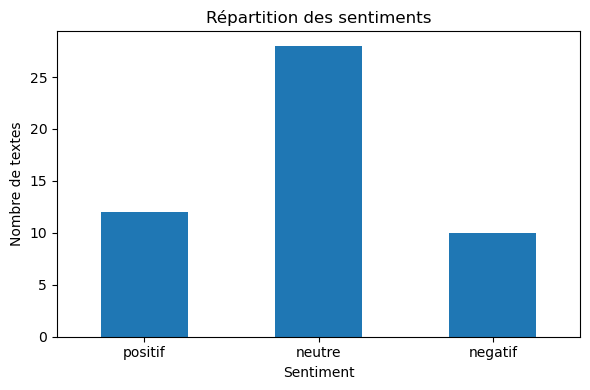

In [190]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('data/reddit_sentiment_results.csv')
counts = df['ressenti'].value_counts().reindex(['positif','neutre','negatif']).fillna(0)

plt.figure(figsize=(6,4))
counts.plot(kind='bar')
plt.title('Répartition des sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Nombre de textes')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('output/sentiment_plot.png', dpi=150)
plt.show()


### **Le setup de l’environnement**

### Installer les dépendances nécessaires grâce au fichier requirements.txt

In [ ]:
pip install -r requirements.txt